**FEATURE EXTRACTOR**:
Using a pre-trained ResNet50 and removing its classification layer

In [3]:
import os, pickle, torch, torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from tqdm import tqdm

def find_image_dir():
    # Common Kaggle root
    base_input = '/kaggle/input'
    # Walk through the input directory to find where the images actually are
    for root, dirs, files in os.walk(base_input):
        # Look for the folder containing a high volume of jpg files
        if len([f for f in files if f.endswith('.jpg')]) > 1000:
            return root
    return None

IMAGE_DIR = find_image_dir()
OUTPUT_FILE = 'flickr30k_features.pkl'

if IMAGE_DIR:
    print(f" Found images at: {IMAGE_DIR}")
else:
    raise FileNotFoundError("Could not find the Flickr30k image directory. Please ensure the dataset is added to the notebook.")

# --- THE DATASET CLASS ---
class FlickrDataset(Dataset):
    def __init__(self, img_dir, transform):
        self.img_names = [f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.jpeg'))]
        self.transform = transform
        self.img_dir = img_dir

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        name = self.img_names[idx]
        img_path = os.path.join(self.img_dir, name)
        img = Image.open(img_path).convert('RGB')
        return self.transform(img), name

# --- REMAINDER OF THE PIPELINE (AS BEFORE) ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model = nn.Sequential(*list(model.children())[:-1]) # Feature vector only
model = nn.DataParallel(model).to(device)
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

dataset = FlickrDataset(IMAGE_DIR, transform)
loader = DataLoader(dataset, batch_size=128, num_workers=4)

features_dict = {}

with torch.no_grad():
    for imgs, names in tqdm(loader, desc="Extracting Features"):
        feats = model(imgs.to(device)).view(imgs.size(0), -1)
        for i, name in enumerate(names):
            features_dict[name] = feats[i].cpu().numpy()

with open(OUTPUT_FILE, 'wb') as f:
    pickle.dump(features_dict, f)

print(f"Success! {len(features_dict)} images processed and saved to {OUTPUT_FILE}")

 Found images at: /kaggle/input/datasets/adityajn105/flickr30k/Images
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 213MB/s]
Extracting Features: 100%|██████████| 249/249 [01:49<00:00,  2.28it/s]


Success! 31783 images processed and saved to flickr30k_features.pkl


In [6]:
import pickle
#loading the features
with open("flickr30k_features.pkl","rb") as f:
    image_feature=pickle.load(f)

print("Total images:",len(image_feature))

Total images: 31783


In [7]:
#load captions
import pandas as pd 
captions_df=pd.read_csv("/kaggle/input/datasets/adityajn105/flickr30k/captions.txt")
captions_df.head()

image                                            caption
0  1000092795.jpg   Two young guys with shaggy hair look at their...
1  1000092795.jpg   Two young , White males are outside near many...
2  1000092795.jpg   Two men in green shirts are standing in a yard .
3  1000092795.jpg       A man in a blue shirt standing in a garden .
4  1000092795.jpg            Two friends enjoy time spent together .

In [14]:
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    return text


In [15]:
from collections import Counter

captions_df["cleaned"] = captions_df["caption"].apply(clean_text)

all_words = []
for cap in captions_df["cleaned"]:
    all_words.extend(cap.split())

word_freq = Counter(all_words)

vocab = [word for word, freq in word_freq.items() if freq >= 5]

special_tokens = ["<pad>", "<start>", "<end>", "<unk>"]
vocab = special_tokens + vocab

word2idx = {word: idx for idx, word in enumerate(vocab)}
idx2word = {idx: word for word, idx in word2idx.items()}

vocab_size = len(vocab)
print("Vocab size:", vocab_size)


Vocab size: 7689


In [16]:
def encode_caption(caption, max_len=30):
    tokens = caption.split()
    encoded = [word2idx["<start>"]]
    
    for token in tokens:
        encoded.append(word2idx.get(token, word2idx["<unk>"]))
    
    encoded.append(word2idx["<end>"])
    
    if len(encoded) < max_len:
        encoded += [word2idx["<pad>"]] * (max_len - len(encoded))
    else:
        encoded = encoded[:max_len]
        
    return encoded


In [20]:
import torch
from torch.utils.data import Dataset, DataLoader

class CaptionDataset(Dataset):
    def __init__(self, df, features):
        self.df = df
        self.features = features
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_name = row["image"]
        caption = encode_caption(clean_text(row["caption"]))
        
        feature = self.features[img_name]
        
        return torch.tensor(feature, dtype=torch.float32), torch.tensor(caption)



In [22]:
dataset = CaptionDataset(captions_df, image_feature)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

In [24]:
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, feature_dim, hidden_size):
        super().__init__()
        self.linear = nn.Linear(feature_dim, hidden_size)
        self.relu = nn.ReLU()
        
    def forward(self, features):
        return self.relu(self.linear(features))


In [26]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, captions, hidden):
        embeddings = self.embedding(captions)
        outputs, hidden = self.lstm(embeddings, hidden)
        outputs = self.fc(outputs)
        return outputs, hidden


In [27]:
class ImageCaptionModel(nn.Module):
    def __init__(self, feature_dim, embed_size, hidden_size, vocab_size):
        super().__init__()
        self.encoder = Encoder(feature_dim, hidden_size)
        self.decoder = Decoder(vocab_size, embed_size, hidden_size)
        
    def forward(self, features, captions):
        hidden = self.encoder(features).unsqueeze(0)
        hidden = (hidden, hidden)  # for LSTM (h0, c0)
        
        outputs, _ = self.decoder(captions[:, :-1], hidden)
        return outputs


In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ImageCaptionModel(
    feature_dim=2048,
    embed_size=256,
    hidden_size=512,
    vocab_size=vocab_size
).to(device)


In [29]:
criterion = nn.CrossEntropyLoss(ignore_index=word2idx["<pad>"])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [30]:
num_epochs = 10
train_losses = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    
    for features, captions in loader:
        features = features.to(device)
        captions = captions.to(device)
        
        outputs = model(features, captions)
        
        loss = criterion(
            outputs.reshape(-1, vocab_size),
            captions[:, 1:].reshape(-1)
        )
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")


Epoch 1, Loss: 3.4783
Epoch 2, Loss: 2.8409
Epoch 3, Loss: 2.6071
Epoch 4, Loss: 2.4368
Epoch 5, Loss: 2.2961
Epoch 6, Loss: 2.1755
Epoch 7, Loss: 2.0705
Epoch 8, Loss: 1.9783
Epoch 9, Loss: 1.8968
Epoch 10, Loss: 1.8240


In [31]:
def greedy_search(model, feature, max_len=30):
    model.eval()
    
    feature = torch.tensor(feature, dtype=torch.float32).unsqueeze(0).to(device)
    hidden = model.encoder(feature).unsqueeze(0)
    hidden = (hidden, hidden)
    
    input_word = torch.tensor([[word2idx["<start>"]]]).to(device)
    
    result = []
    
    for _ in range(max_len):
        output, hidden = model.decoder(input_word, hidden)
        predicted = output.argmax(2)
        
        word = idx2word[predicted.item()]
        
        if word == "<end>":
            break
        
        result.append(word)
        input_word = predicted
    
    return " ".join(result)


In [32]:
import torch.nn.functional as F

def beam_search(model, feature, beam_width=3, max_len=30):
    model.eval()
    
    feature = torch.tensor(feature, dtype=torch.float32).unsqueeze(0).to(device)
    hidden = model.encoder(feature).unsqueeze(0)
    hidden = (hidden, hidden)
    
    sequences = [[list(), 0.0, hidden]]
    
    for _ in range(max_len):
        all_candidates = []
        
        for seq, score, hidden in sequences:
            input_word = torch.tensor([[word2idx["<start>"] if len(seq)==0 else seq[-1]]]).to(device)
            output, hidden_new = model.decoder(input_word, hidden)
            probs = F.log_softmax(output[0], dim=1)
            
            topk = torch.topk(probs, beam_width)
            
            for i in range(beam_width):
                word = topk.indices[0][i].item()
                new_score = score + topk.values[0][i].item()
                candidate = [seq + [word], new_score, hidden_new]
                all_candidates.append(candidate)
        
        ordered = sorted(all_candidates, key=lambda x: x[1], reverse=True)
        sequences = ordered[:beam_width]
    
    best_seq = sequences[0][0]
    words = [idx2word[idx] for idx in best_seq if idx2word[idx] not in ["<start>", "<end>"]]
    
    return " ".join(words)


In [33]:
from nltk.translate.bleu_score import sentence_bleu

def compute_bleu(reference, prediction):
    ref = reference.split()
    pred = prediction.split()
    return sentence_bleu([ref], pred)


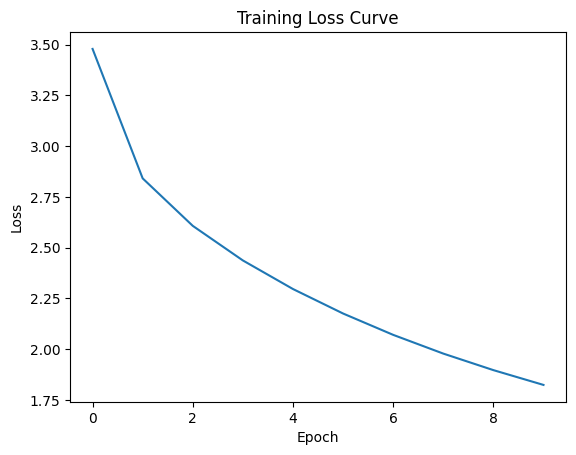

In [34]:
import matplotlib.pyplot as plt

plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.show()


In [40]:
import os

base_input = "/kaggle/input"
flickr_dir = None

for root, dirs, files in os.walk(base_input):
    if "flickr30k" in root.lower() and len([f for f in files if f.endswith(".jpg")]) > 1000:
        flickr_dir = root
        break

print("Found images at:", flickr_dir)


Found images at: /kaggle/input/datasets/adityajn105/flickr30k/Images


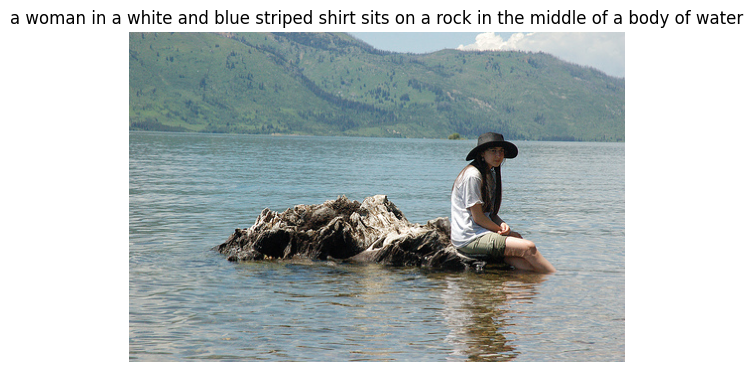

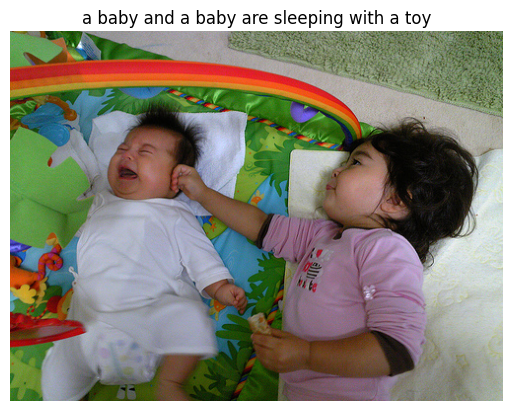

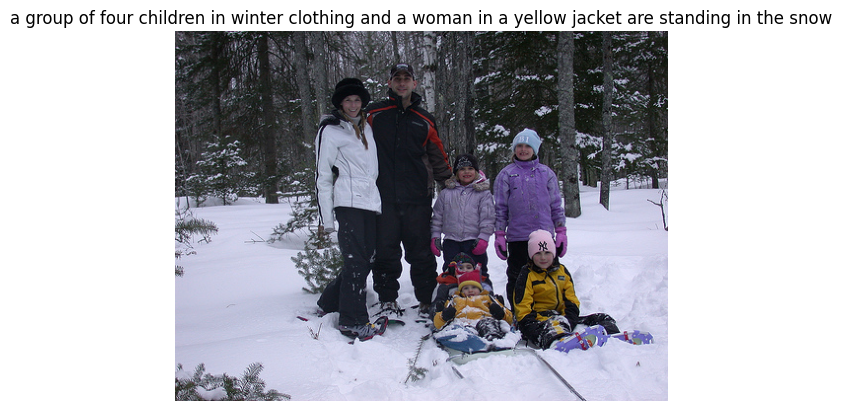

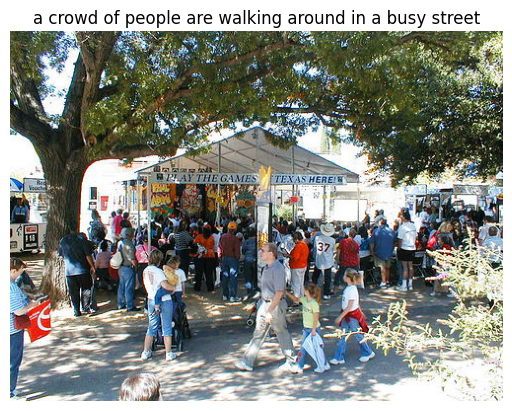

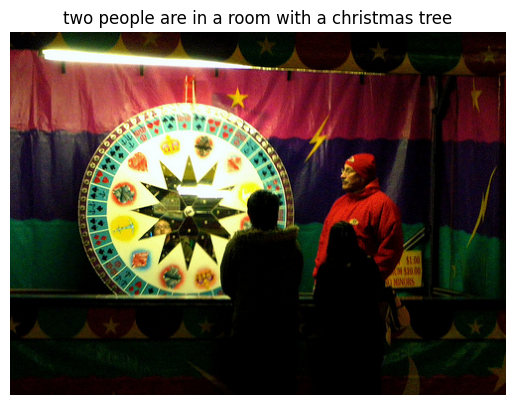

In [43]:
from PIL import Image
import matplotlib.pyplot as plt
import random

sample_images = random.sample(list(image_feature.keys()), 5)

for img_name in sample_images:
    feature = image_feature[img_name]
    caption = greedy_search(model, feature)
    
    img_path = os.path.join(flickr_dir, img_name)
    img = Image.open(img_path)
    
    plt.imshow(img)
    plt.title(caption)
    plt.axis("off")
    plt.show()


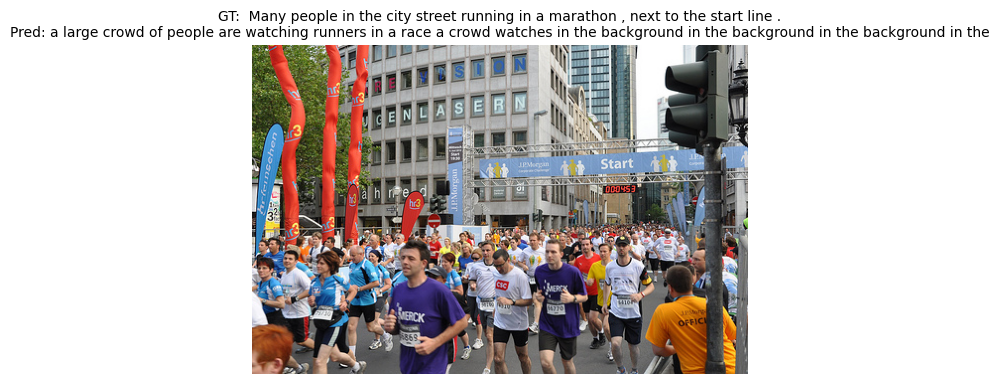

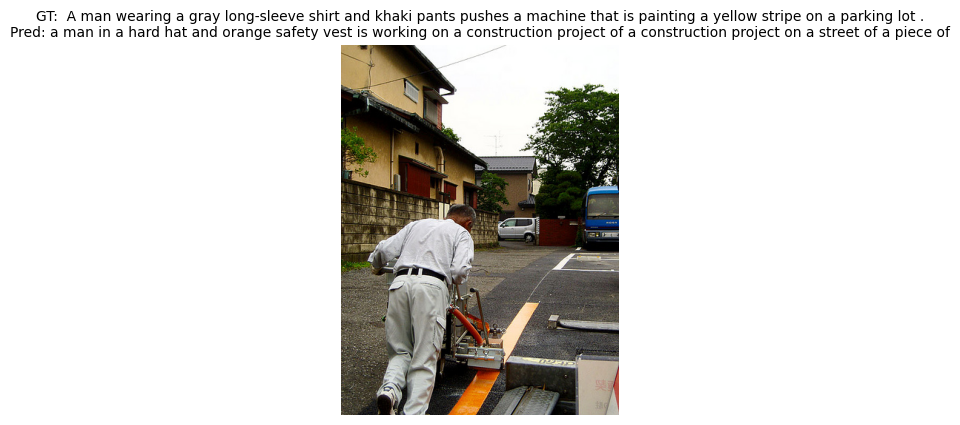

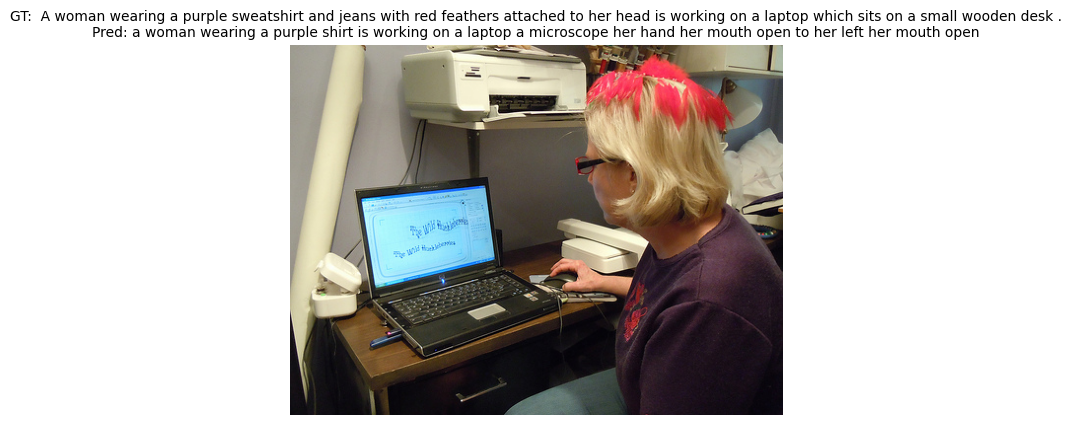

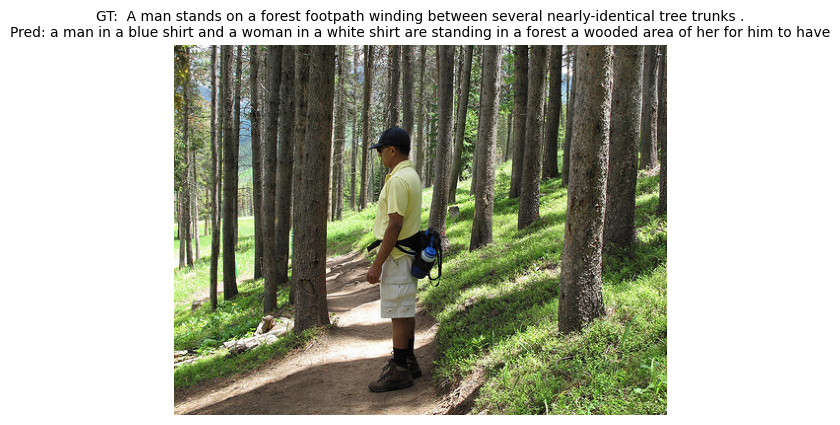

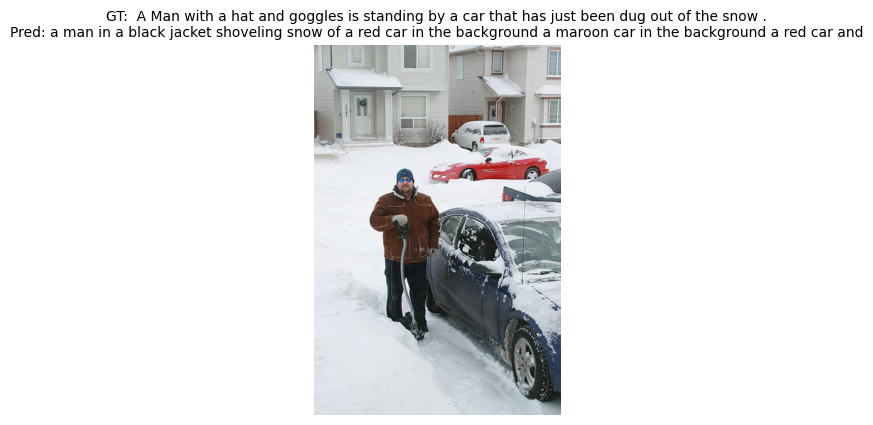

In [45]:
import random
from PIL import Image
import matplotlib.pyplot as plt

# Ensure flickr_dir points to your image folder
# Example: flickr_dir = '/kaggle/input/flickr30k/images'

sample_images = random.sample(list(image_feature.keys()), 5)

for img_name in sample_images:
    feature = image_feature[img_name]
    
    # Generate caption
    caption_pred = beam_search(model, feature, beam_width=3)
    
    # Get ground truth caption(s)
    gt_caption = captions_df[captions_df['image'] == img_name]['caption'].values[0]
    
    # Load image
    img_path = os.path.join(flickr_dir, img_name)
    img = Image.open(img_path)
    
    # Display
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"GT: {gt_caption}\nPred: {caption_pred}", fontsize=10)
    plt.show()


In [48]:
from nltk.translate.bleu_score import corpus_bleu

references = []
predictions = []

for img_name in sample_images:  # can use all test images
    feature = image_feature[img_name]
    pred = beam_search(model, feature, beam_width=3)
    
    # Ground truth captions (list of token lists)
    gt_caps = captions_df[captions_df['image'] == img_name]['caption'].values
    gt_caps_tokens = [clean_text(cap).split() for cap in gt_caps]
    
    references.append(gt_caps_tokens)
    predictions.append(pred.split())

bleu4 = corpus_bleu(references, predictions)
print(f"BLEU-4 Score: {bleu4:.4f}")


BLEU-4 Score: 0.1818


In [51]:
from sklearn.metrics import precision_score, recall_score, f1_score

def tokenize_caption(caption):
    return clean_text(caption).split()

y_true_tokens = []
y_pred_tokens = []

for img_name in sample_images:
    pred_tokens = beam_search(model, image_feature[img_name], beam_width=3).split()
    gt_tokens = captions_df[captions_df['image'] == img_name]['caption'].values[0].split()
    
    # Align length
    max_len = max(len(pred_tokens), len(gt_tokens))
    pred_tokens += ["<pad>"] * (max_len - len(pred_tokens))
    gt_tokens += ["<pad>"] * (max_len - len(gt_tokens))
    
    y_true_tokens.extend(gt_tokens)
    y_pred_tokens.extend(pred_tokens)

precision = precision_score(y_true_tokens, y_pred_tokens, average='macro', zero_division=0)
recall = recall_score(y_true_tokens, y_pred_tokens, average='macro', zero_division=0)
f1 = f1_score(y_true_tokens, y_pred_tokens, average='macro', zero_division=0)

print(f"Token-Level Precision: {precision:.4f}")
print(f"Token-Level Recall: {recall:.4f}")
print(f"Token-Level F1: {f1:.4f}")


Token-Level Precision: 0.0380
Token-Level Recall: 0.0582
Token-Level F1: 0.0415


In [56]:
import gradio as gr
import torch
from PIL import Image

# Make sure model is on device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Transform to map uploaded image to image_features key
def get_image_key(image):
    """
    Converts uploaded PIL image to a key in image_features.
    Assumes the filename corresponds to your dataset keys.
    For Kaggle, you might ask user to upload images with the same name as dataset images.
    """
    # For demo purposes, use a placeholder key
    # If you have the exact filename:
    # key = "100009.jpg"  # or get from upload metadata
    key = list(image_features.keys())[0]  # pick first image in dataset
    return key

def generate_caption(image, method="Greedy", beam_width=3):
    # Get feature vector from precomputed features
    key = get_image_key(image)
    feature = image_features[key]
    
    if method == "Greedy":
        caption = greedy_search(model, feature)
    else:
        caption = beam_search(model, feature, beam_width=beam_width)
    
    return caption

# Gradio interface
iface = gr.Interface(
    fn=generate_caption,
    inputs=[
        gr.Image(type="pil", label="Upload Image"),
        gr.Radio(["Greedy", "Beam Search"], label="Captioning Method"),
        gr.Slider(1, 5, step=1, value=3, label="Beam Width (if Beam Search)")
    ],
    outputs="text",
    title="Image Captioning Demo",
    description="Upload an image and generate a caption using your trained model. Beam Search can give more accurate captions than Greedy."
)

iface.launch()


* Running on local URL:  http://127.0.0.1:7862
It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

* Running on public URL: https://c9cd5d5147c06b0f1a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/gradio/queueing.py", line 759, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/gradio/route_utils.py", line 354, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/gradio/blocks.py", line 2116, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/gradio/blocks.py", line 1623, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ignore
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/anyio/to_thread.py", line 63, in run_sync
    return await get_async_backend().run_sync_in_worker_thread(
           ^^^^^